## 1. import data

In [133]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler 

In [3]:
import pandas as pd

# File path
file_path = '/Users/xinyizhang/Desktop/SP600.csv'

# Read the CSV file
df = pd.read_csv(file_path)

print(df.head())

         Date   Adj Close   Volume Ticker    Return
0  2019-09-30  150.984802   982800    AAP       NaN
1  2019-10-01  152.710114  1086300    AAP  0.011427
2  2019-10-02  148.757462   975400    AAP -0.025883
3  2019-10-03  145.927643   918100    AAP -0.019023
4  2019-10-04  146.000671   749000    AAP  0.000500


In [5]:
""" 
transfer the dataset into a 3d dataset
- axis 0: tickers
- axis 1: dates
- axis 2; features
"""

features = ['Adj Close', 'Volume', 'Return']

df_pivot = df.pivot_table(index='Date', columns='Ticker', values=features)
df_pivot.fillna(0, inplace=True)

tickers = df['Ticker'].unique()  
dates = df['Date'].unique() 

df_3d = np.stack([df_pivot[feature].values.T for feature in features], axis=2)

In [7]:
df_3d.shape

(600, 1258, 3)

## 2. feature engineering

### (1) rolling volatility

In [11]:
# calculate the rolling window standard deviation of returns as new feature
returns = df_3d[:,:,2]

# create an empty array to store rolling volatilities
window_size = 10
rolling_volatility = np.zeros_like(returns)

# loop over each stock and compute rolling volatility
for i in range(returns.shape[0]):
    for j in range(returns.shape[1]-window_size+1):
        rolling_volatility[i,j] = np.std(returns[i,j:j+window_size])

In [12]:
rolling_volatility.shape

(600, 1258)

### (2) RSI

In [14]:
def compute_rsi(prices, window=14):

    # calculate daily price changes
    delta = np.diff(prices)

    # create two arrays: one for gians and one for losses
    gain = np.maximum(delta,0)
    loss = -np.minimum(delta,0)

    avg_gain = np.zeros_like(prices)
    avg_loss = np.zeros_like(prices)
    avg_gain[window] = np.mean(gain[:window])
    avg_loss[window] = np.mean(loss[:window])

    # compute the rolling averages gains and losses
    for i in range(window+1, len(prices)):
        avg_gain[i] = (avg_gain[i - 1] * (window - 1) + gain[i - 1]) / window
        avg_loss[i] = (avg_loss[i - 1] * (window - 1) + loss[i - 1]) / window

    # Avoid division by zero
    avg_loss = np.where(avg_loss == 0, 1e-10, avg_loss)

    # Calculate the Relative Strength (RS) and the Relative Strength Index (RSI)
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [15]:
# calculate the RSI as new feature
adj_close = df_3d[:,:,0]

# create an empty array to store rsi
window_size = 14
rsi = np.zeros_like(adj_close)

# Loop through each stock to calculate RSI
for i in range(adj_close.shape[0]):
    rsi[i, window_size:] = compute_rsi(adj_close[i], window=window_size)[window_size:]

In [16]:
rsi.shape

(600, 1258)

In [17]:
# Add a new axis to rolling_volatility and rsi to make them 3D arrays (n_stocks, n_dates, 1)
rolling_volatility_3d = rolling_volatility[:, :, np.newaxis]  # Convert to shape (n_stocks, n_dates, 1)
rsi_3d = rsi[:, :, np.newaxis]  # Convert to shape (n_stocks, n_dates, 1)

# Concatenate along the feature axis (axis=2)
df_new = np.concatenate((df_3d, rolling_volatility_3d, rsi_3d), axis=2)

In [18]:
df_new.shape

(600, 1258, 5)

## 3. train the model

In [20]:
# we don't use adj_close as feature
df_new = df_new[:,:,1:]

In [31]:
n_stocks, n_dates, n_features = df_new.shape

# Define the size of each subset 
subset_size = 50

# name of features
features = ['volume','daily_return','rolling_volatility','rsi']

In [33]:
# Flatten the 3D array to 2D for DBSCAN (rows = stock + date, columns = features)
df_flat = df_new.reshape(df_new.shape[0] * df_new.shape[1], -1)
df_flat = pd.DataFrame(df_flat, columns=features)

In [35]:
# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_flat)

In [37]:
df_scaled.shape

(754800, 4)

### (1) Interaction of two features

In [39]:
def dbscan_model(df, feature1, feature2):
    all_labels = []  # Initialize the list to collect labels
    all_scaled_data = []  # List to collect all scaled data
    
    # Loop over the dataset in chunks (subset by stocks)
    for i in range(0, n_stocks, subset_size):
        
        # Extract the subset of data
        subset_data = df[i:i + subset_size, :, :]
    
        # Flatten the 3D array to 2D for DBSCAN (rows = stock + date, columns = features)
        subset_flat = subset_data.reshape(subset_data.shape[0] * subset_data.shape[1], -1)

        # Convert flattened data into a Dataframe
        subset_flat = pd.DataFrame(subset_flat, columns=features)
        
        # Standardize the data
        scaler = StandardScaler()
        subset_scaled = scaler.fit_transform(subset_flat[[feature1, feature2]])

        # Append the scaled data for later plotting
        all_scaled_data.append(subset_scaled)
    
        # Apply DBSCAN on the subset
        dbscan = DBSCAN(eps=0.8, min_samples=10)
        subset_labels = dbscan.fit_predict(subset_scaled)
    
        # Store the labels (reshape back to 2D: stocks × dates)
        subset_labels_reshaped = subset_labels.reshape(subset_data.shape[0], subset_data.shape[1])
        all_labels.append(subset_labels_reshaped)
    
    # Concatenate all labels and scaled data
    final_labels = np.concatenate(all_labels, axis=0)
    all_scaled_data = np.concatenate(all_scaled_data, axis=0)

    # Count the number of anomalies
    anomalies = (final_labels == -1)
    n_anomalies = np.sum(anomalies)
    print(f"Number of anomalies detected: {n_anomalies}")

    # Plot using the full dataset
    plt.scatter(all_scaled_data[:, 0], all_scaled_data[:, 1], c=final_labels)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title("DBSCAN Clustering Results")
    plt.colorbar(label="Cluster Labels")
    plt.show()

    return final_labels, all_scaled_data

Number of anomalies detected: 615


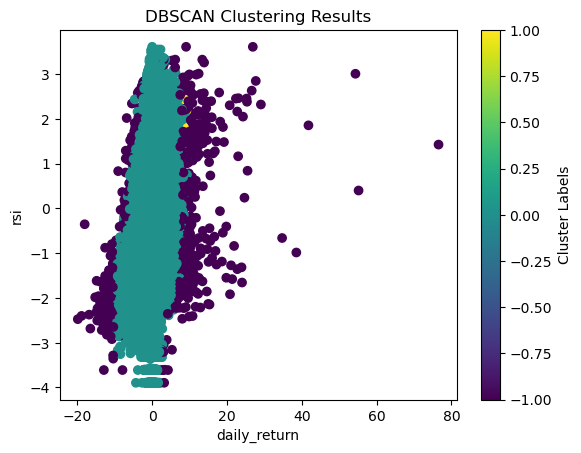

In [41]:
return_rsi_label, return_rsi_data = dbscan_model(df_new, 'daily_return', 'rsi')

#### Explaination:
- points that do not belong tp any cluster (outliers) are labeled as -1
- the outliers represent anomalies or unusual behaviors in terms of the relationship between two features, which DBSCAN identified as not fitting into any cluster
- these two features are correlated based on the clustering pattern, with outliers exhibiting more extreme values in either or both metrics

In [43]:
return_rsi_data

array([[-0.02675812, -3.60478136],
       [ 0.3373267 , -3.60478136],
       [-0.85144508, -3.60478136],
       ...,
       [ 0.00899914,  1.0311146 ],
       [ 0.33097766,  1.15321359],
       [ 0.48631374,  1.31925459]])

In [45]:
subset_data = return_rsi_data[:100] 

#### - Use K-distance to find the best epsilon

In [53]:
neigh = NearestNeighbors(n_neighbors=9)
nbrs = neigh.fit(subset_data)
distances, indices = nbrs.kneighbors(subset_data)

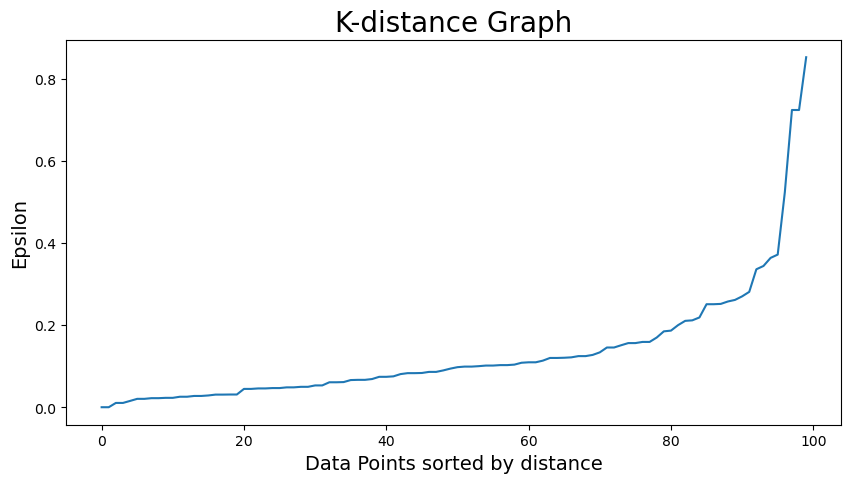

In [57]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

### (2) All features

In [97]:
df_new.shape

(600, 1258, 4)

In [103]:
all_labels = []  # Initialize the list to collect labels
all_scaled_data = []  # List to collect all scaled data
    
# Loop over the dataset in chunks (subset by stocks)
for i in range(0, n_stocks, subset_size):
    
    # Extract the subset of data
    subset_data = df_new[i:i + subset_size, :, :]

    # Flatten the 3D array to 2D for DBSCAN (rows = stock + date, columns = features)
    subset_flat = subset_data.reshape(subset_data.shape[0] * subset_data.shape[1], -1)

    # Convert flattened data into a Dataframe
    subset_flat = pd.DataFrame(subset_flat, columns=features)
    
    # Standardize the data
    scaler = StandardScaler()
    subset_scaled = scaler.fit_transform(subset_flat)

    # Append the scaled data for later plotting
    all_scaled_data.append(subset_scaled)

    # Apply DBSCAN on the subset
    dbscan = DBSCAN(eps=0.8, min_samples=10)
    subset_labels = dbscan.fit_predict(subset_scaled)

    # Store the labels (reshape back to 2D: stocks × dates)
    subset_labels_reshaped = subset_labels.reshape(subset_data.shape[0], subset_data.shape[1])
    all_labels.append(subset_labels_reshaped)

# Concatenate all labels and scaled data
final_labels = np.concatenate(all_labels, axis=0)
all_scaled_data = np.concatenate(all_scaled_data, axis=0)

In [104]:
# Count the number of anomalies
anomalies = (final_labels == -1)
n_anomalies = np.sum(anomalies)
print(f"Number of anomalies detected: {n_anomalies}")

Number of anomalies detected: 12177


array([[ 0.13091978, -0.02675812, -0.56087805, -3.60478136],
       [ 0.19213954,  0.3373267 , -0.56270157, -3.60478136],
       [ 0.12654272, -0.85144508, -0.53531613, -3.60478136],
       ...,
       [ 0.20921805,  0.00899914, -1.27188939,  1.0311146 ],
       [ 0.14937813,  0.33097766, -1.27188939,  1.15321359],
       [ 0.49907932,  0.48631374, -1.27188939,  1.31925459]])

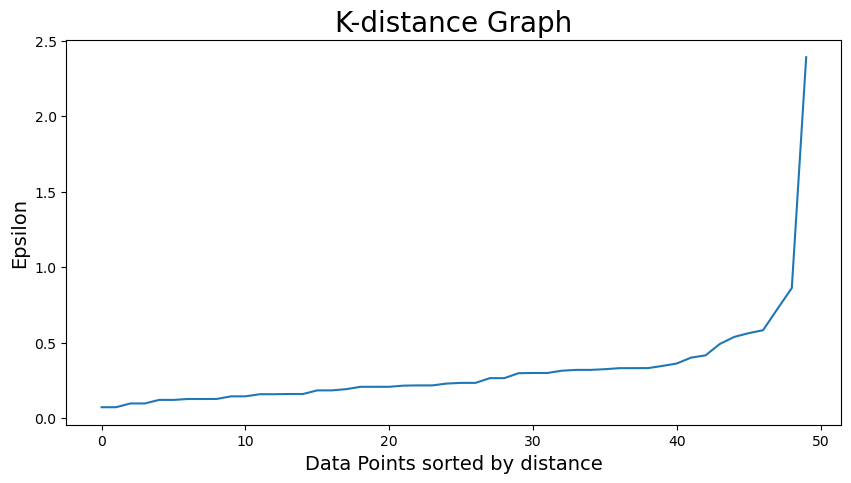

In [129]:
subset_data = all_scaled_data[:50] 
neigh = NearestNeighbors(n_neighbors=20)
nbrs = neigh.fit(subset_data)
distances, indices = nbrs.kneighbors(subset_data)

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

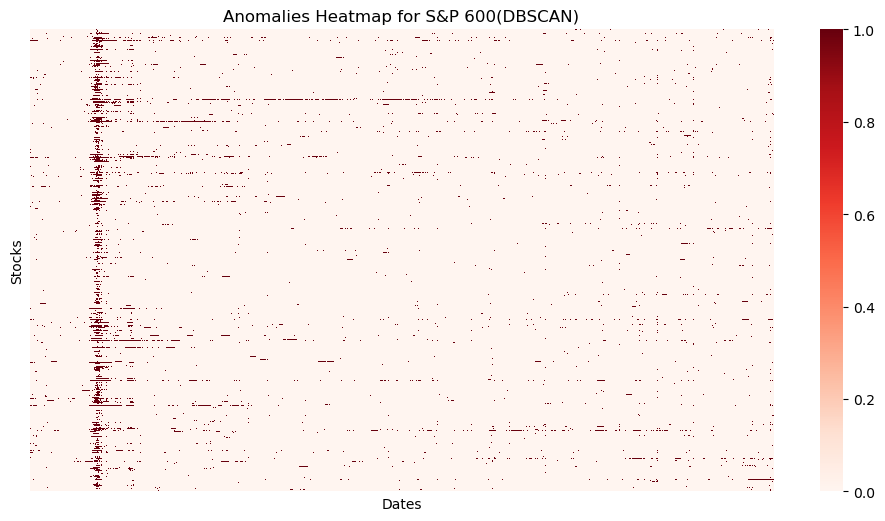

In [107]:
# Create a binary matrix where 1 = anomaly (-1 label) and 0 = normal
anomaly_matrix = np.where(final_labels == -1, 1, 0)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(anomaly_matrix, cmap="Reds", cbar=True, xticklabels=False, yticklabels=False)
plt.title("Anomalies Heatmap for S&P 600(DBSCAN)")
plt.xlabel("Dates")
plt.ylabel("Stocks")
plt.show()

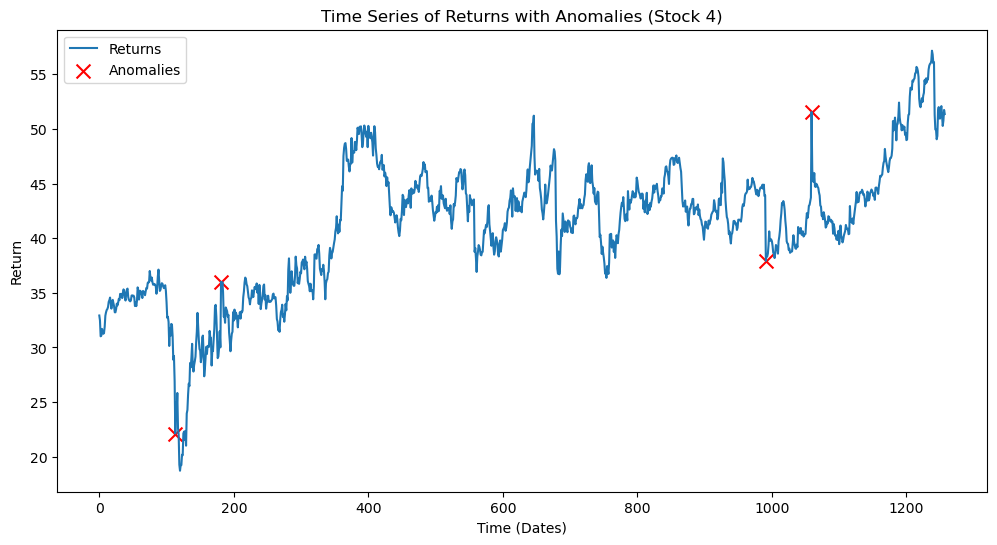

In [111]:
# Choose a stock index to visualize
stock_index = 4  # Change this to the stock you want to visualize

# Get the time series of returns for the selected stock
stock_returns = df_3d[stock_index, :, 0]  # Assuming 'Return' is at index 0 in the feature set

# Get the anomaly labels for this stock
stock_anomalies = final_labels[stock_index] == -1

# Plot the time series of returns
plt.figure(figsize=(12, 6))
plt.plot(stock_returns, label="Returns")
plt.scatter(np.where(stock_anomalies)[0], stock_returns[stock_anomalies], color='red', label='Anomalies', marker='x', s=100)

plt.title(f"Time Series of Returns with Anomalies (Stock {stock_index})")
plt.xlabel("Time (Dates)")
plt.ylabel("Return")
plt.legend()
plt.show()

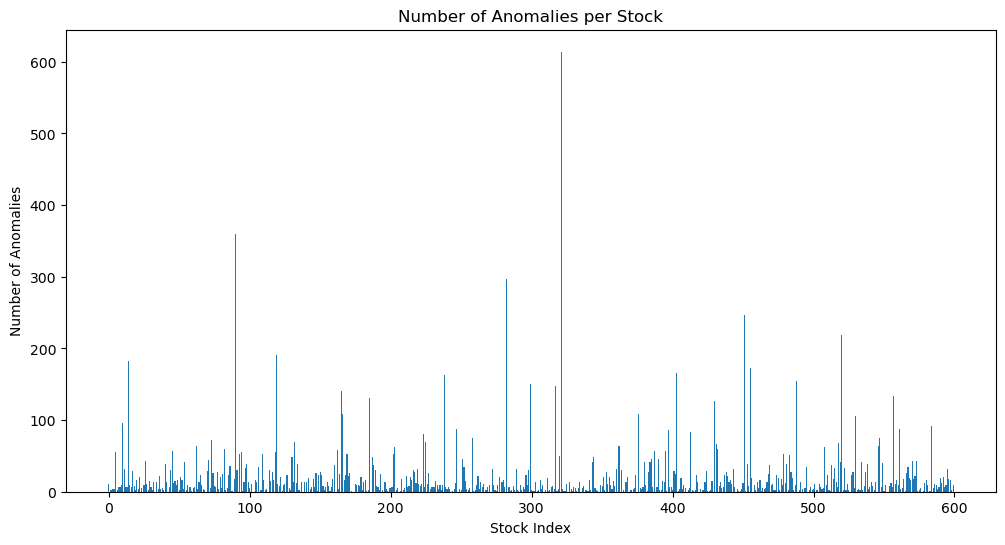

In [113]:
# Count the number of anomalies (label -1) for each stock
anomalies_per_stock = np.sum(final_labels == -1, axis=1)

# Plot the number of anomalies for each stock
plt.figure(figsize=(12, 6))
plt.bar(range(final_labels.shape[0]), anomalies_per_stock)
plt.title("Number of Anomalies per Stock")
plt.xlabel("Stock Index")
plt.ylabel("Number of Anomalies")
plt.show()

In [131]:
file_path = '/Users/xinyizhang/Desktop/overall_anomalies.csv'

# Read the CSV file
df_sup = pd.read_csv(file_path)

print(df_sup.head())

         Date Ticker  Overall_Anomaly
0  2019-09-30    AAP                0
1  2019-10-01    AAP                0
2  2019-10-02    AAP                0
3  2019-10-03    AAP                0
4  2019-10-04    AAP                0


In [135]:
# 用真实的标签评估DBSCAN的聚类结果
ari_score = adjusted_rand_score(df_sup, final_labels)
print(f"Adjusted Rand Index: {ari_score}")

TypeError: '<' not supported between instances of 'int' and 'str'

In [137]:
print(df_sup.dtypes)

Date               object
Ticker             object
Overall_Anomaly     int64
dtype: object


In [141]:
final_labels.shape

(600, 1258)

In [155]:
unsup_anom = final_labels.flatten()

In [159]:
unsup_anom

array([0, 0, 0, ..., 1, 1, 1])

In [151]:
sup_anom = df_sup[:,:-1]

InvalidIndexError: (slice(None, None, None), slice(None, -1, None))

In [153]:
sup_anom

,Date,Ticker,Overall_Anomaly
0,2019-09-30,AAP,0
1,2019-10-01,AAP,0
2,2019-10-02,AAP,0
3,2019-10-03,AAP,0
4,2019-10-04,AAP,0
...,...,...,...
736393,2024-09-20,ZWS,1
736394,2024-09-23,ZWS,0
736395,2024-09-24,ZWS,0
736396,2024-09-25,ZWS,0
